In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import string

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Read the training data using pandas
train_df = pd.read_csv('/content/Tweets-train.csv')
train_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
1,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
2,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
3,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
4,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)


In [ ]:
# select only the 'sentiment' and 'text' columns
train_df = train_df[['airline_sentiment', 'text']]

In [ ]:
# function to clean tweets
def clean_tweet(tweet):
    # Remove references with '@'
    tweet = re.sub(r'@\S+', '', tweet)

    # Remove links (http, https)
    tweet = re.sub(r'http\S+|https\S+', '', tweet)

    # Remove punctuations
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # Remove emoticons (you may need a more comprehensive list of emoticons)
    tweet = re.sub(r'(:|;|=)(?:-)?(?:\)|\(|D|P)', '', tweet)

    return tweet

In [ ]:
# Apply the clean_tweet function to the 'text' column and save changes in a new column 'clean_text'
train_df['clean_text'] = train_df['text'].apply(clean_tweet)


In [ ]:
# Display randomely generated 10 tweets for each sentiment after cleaning
for sentiment in train_df['airline_sentiment'].unique():
    print(f"\nRandomly generated 10 cleaned tweets for sentiment: {sentiment}")
    sample_tweets = train_df[train_df['airline_sentiment'] == sentiment]['clean_text'].sample(10, random_state=42)
    print(sample_tweets)


Randomly generated 10 cleaned tweets for sentiment: positive
1949      I just received notification of inflight WiFi...
5733      today my family gets to experience mosaic sta...
3381      A to the Safety Dos and Donts Announcer Fligh...
6895      we called and were able to get rescheduled Th...
3494      were pulling off the runway now Making new fr...
10032      Those are very beautiful photos Thx Would ma...
2618      Your staff both on deck and in the cabin on U...
9569      FANTASTIC thanks again for coming thru with g...
81         amazing customer  service again  RaeAnn in S...
4562                                   Awesome Sending now
Name: clean_text, dtype: object

Randomly generated 10 cleaned tweets for sentiment: neutral
6533      that is certainly not the impression shes under
2464      Definately not an award for employer of the ...
3309     Could you maybe hook   with some imagine drag...
1099                         on a flight at 1130 tomorrow
6612       can i please

In [ ]:
# Apply the remove_stopwords_and_get_common_words function to the 'clean_text' column
train_df['clean_text_no_stopwords'], common_words_list = zip(*train_df['clean_text'].apply(remove_stopwords_and_get_common_words))

# Display most common 15 words for each sentiment
for sentiment, common_words in zip(train_df['airline_sentiment'].unique(), common_words_list):
    print(f"\nMost common 15 words for sentiment: {sentiment}")
    print(common_words)

# Remove common words from all tweets
common_words_set = set(word for common_words in common_words_list for word, _ in common_words)
train_df['final_clean_text'] = train_df['clean_text_no_stopwords'].apply(lambda x: ' '.join([word for word in x.split() if word not in common_words_set]))

# Display the final cleaned and processed DataFrame
print("\nFinal Cleaned and Processed DataFrame:")
print(train_df[['airline_sentiment', 'final_clean_text']].head())


Most common 15 words for sentiment: positive
[('plus', 1), ('youve', 1), ('added', 1), ('commercials', 1), ('experience', 1), ('tacky', 1)]

Most common 15 words for sentiment: neutral
[('didnt', 1), ('today', 1), ('must', 1), ('mean', 1), ('need', 1), ('take', 1), ('another', 1), ('trip', 1)]

Most common 15 words for sentiment: negative
[('really', 1), ('aggressive', 1), ('blast', 1), ('obnoxious', 1), ('entertainment', 1), ('guests', 1), ('faces', 1), ('amp', 1), ('little', 1), ('recourse', 1)]

Final Cleaned and Processed DataFrame:
  airline_sentiment final_clean_text
0          positive                 
1           neutral                 
2          negative                 
3          negative                 
4          positive                 


In [ ]:
# Function to remove stopwords and list down most common 15 words
def remove_stopwords_and_get_common_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]

    # List down most common 15 words
    fdist = FreqDist(words)
    common_words = fdist.most_common(15)

    return ' '.join(words)

# Apply the modified function to the 'clean_text' column in the test data
test_df['clean_text_no_stopwords'] = test_df['clean_text'].apply(remove_stopwords_and_get_common_words)
test_df['clean_text_no_stopwords'] = test_df['clean_text_no_stopwords'].apply(lambda x: ' '.join([word for word in x.split() if word not in words_to_remove]))
test_df['encoded_sentiment'] = label_encoder.transform(test_df['airline_sentiment'])
X_test = vectorizer.transform(test_df['clean_text_no_stopwords'])

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import nltk

In [ ]:
# Remove specified words from all tweets
words_to_remove = ['americanair', 'united', 'delta', 'southwestair', 'jetblue', 'virginamerica', 'usairways', 'flight', 'plane']
train_df['clean_text_no_stopwords'] = train_df['clean_text_no_stopwords'].apply(lambda x: ' '.join([word for word in x.split() if word not in words_to_remove]))

# List down most common 15 words after removing specified words
for sentiment, common_words in zip(train_df['airline_sentiment'].unique(), common_words_list):
    common_words_after_removal = [word for word, _ in common_words if word not in words_to_remove]
    print(f"\nMost common 15 words for sentiment {sentiment} after removing specified words:")
    print(common_words_after_removal)


Most common 15 words for sentiment positive after removing specified words:
['plus', 'youve', 'added', 'commercials', 'experience', 'tacky']

Most common 15 words for sentiment neutral after removing specified words:
['didnt', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip']

Most common 15 words for sentiment negative after removing specified words:
['really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guests', 'faces', 'amp', 'little', 'recourse']


In [ ]:
# Encode Sentiments using Label Encoder
label_encoder = LabelEncoder()
train_df['encoded_sentiment'] = label_encoder.fit_transform(train_df['airline_sentiment'])

# Vectorize the Text Column using CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['clean_text_no_stopwords'])

# Prepare a multiclass Classification model using RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, train_df['encoded_sentiment'])

RandomForestClassifier(random_state=42)

In [ ]:
# Read the test data
test_df = pd.read_csv('/content/Tweets-test.csv')
test_df = test_df[['airline_sentiment', 'text']]

# Clean, encode, and vectorize the test data
test_df['clean_text'] = test_df['text'].apply(clean_tweet)
test_df['clean_text_no_stopwords'] = test_df['clean_text'].apply(remove_stopwords_and_get_common_words)
test_df['clean_text_no_stopwords'] = test_df['clean_text_no_stopwords'].apply(lambda x: ' '.join([word for word in x.split() if word not in words_to_remove]))
test_df['encoded_sentiment'] = label_encoder.transform(test_df['airline_sentiment'])
X_test = vectorizer.transform(test_df['clean_text_no_stopwords'])

# Predict the sentiments for test data
y_pred = model.predict(X_test)

# Print and explain the Confusion Matrix
conf_matrix = confusion_matrix(test_df['encoded_sentiment'], y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[2266  168   74]
 [ 316  451   84]
 [ 168   82  391]]



Confusion Matrix:
[[2266  168   74]
 [ 316  451   84]
 [ 168   82  391]]


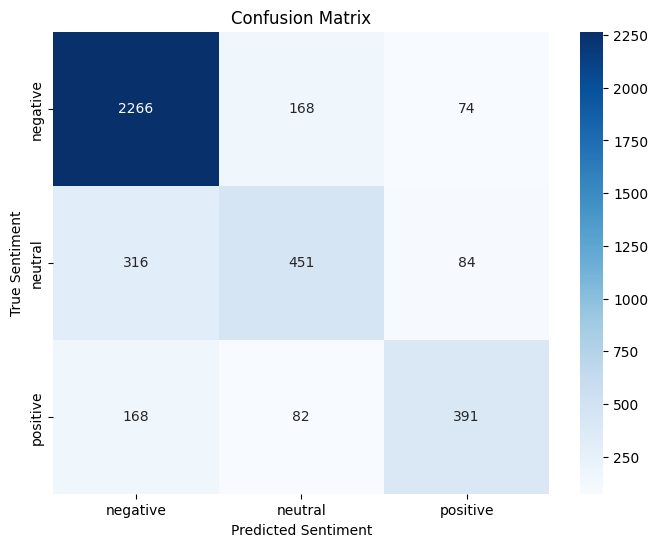


Accuracy: 0.7770


In [ ]:
import matplotlib.pyplot as plt
# Read the test data
test_df = pd.read_csv('/content/Tweets-test.csv')
test_df = test_df[['airline_sentiment', 'text']]

# Clean, encode, and vectorize the test data
test_df['clean_text'] = test_df['text'].apply(clean_tweet)
test_df['clean_text_no_stopwords'] = test_df['clean_text'].apply(remove_stopwords_and_get_common_words)
test_df['clean_text_no_stopwords'] = test_df['clean_text_no_stopwords'].apply(lambda x: ' '.join([word for word in x.split() if word not in words_to_remove]))
test_df['encoded_sentiment'] = label_encoder.transform(test_df['airline_sentiment'])
X_test = vectorizer.transform(test_df['clean_text_no_stopwords'])

# Predict the sentiments for test data
y_pred = model.predict(X_test)

# Print and explain the Confusion Matrix
conf_matrix = confusion_matrix(test_df['encoded_sentiment'], y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix')
plt.show()

# Compute Accuracy of the model
accuracy = accuracy_score(test_df['encoded_sentiment'], y_pred)
print(f"\nAccuracy: {accuracy:.4f}")